In [131]:
#RUN THIS BEFORE USING
%reset
%matplotlib inline
import network_modules as nm
import graph_measures as gm
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
import networkx as nx
import collections
import scipy.signal as sig

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
slider1 = widgets.IntSlider(min=50, max=5000, step=50, value= 50, description = 'n')
slider2 = widgets.IntSlider(min=1, max=10, value=1, description = 'm')
slider3 = widgets.FloatSlider(min=0, max=10, value=1, description = 'a')
slider4 = widgets.FloatSlider(min=0, max=2*np.pi, value=0, description = 'b')
slider5 = widgets.FloatSlider(min=0, max=1, value=0, description = 'c')
slider6 = widgets.FloatSlider(min=0, max=10, value=1, description = 'K')
display(slider1, slider2, slider3, slider4, slider5,slider6)

In [ ]:
n = slider1.value
m = slider2.value
print('n = ',n)
print('m = ',m)
G = nx.barabasi_albert_graph(n, m)

In [ ]:
gm.degree_distribution(G)

In [ ]:
#Parameter Initialization

distributions = [(n,0,2*np.pi,'uniform'),(n,10,2,'normal')]
states = nm.create_vec_states(distributions)
z = np.cos(states[:,0]) + 1j * np.sin(states[:,0])
w = 1j * states[:,1]
x = [[a,b] for a,b in zip(z,w)]

def currynode(w):
    def node(x):   #node function
        return np.array([1j * x[0] * w + x[0]*(1-abs(x[0])),0*1j]) # apply limit cycle term to keep in a circle
    return node

h = [currynode(w) for w in states[:,1]]

def f(x,y): #coupling function
    a = slider3.value
    b = slider4.value
    c = slider5.value
    K = slider6.value
    phi = np.angle(y[0])-np.angle(x[0])
    return np.array([1j * x[0] * complex(K*(np.sin(a*phi+b)+c),0),0*1j])

M = np.identity(n) #Measurement Matrix
N = 0 #Noise Variance

oscillator = nm.nmodel(G,x,h,f,M,N,dt=.01)
oscillator.run(10)
nm.state_course(np.real(nm.reduce_state(0,oscillator.x)))

In [ ]:
def frange(start, stop, step):  
    i = start
    while i < stop:
        yield i
        i += step
        
@interact(off = (0.0,2*np.pi))
def f(off):
    x = np.array([np.cos(x) + 1j*np.sin(x) for x in frange(0,4*np.pi,.1)])
    y = np.array([np.cos(x + off) + 1j*np.sin(x + off) for x in frange(0,4*np.pi,.1)])
    plt.figure()
    plt.plot(np.array(x)[0])
    plt.plot(np.array(y)[0])
    plt.show()
    print(gm.correlation(x,y))
    

In [ ]:
#f, t, s = sig.spectrogram(signal, fs = 1000, window, nperseg, noverlap, nfft)
#f, Pxx = sig.welch(signal, fs = 1000, window, nperseg, noverlap, nfft)
#import pywt
#cA, cD = pywt.dwt([1, 2, 3, 4], 'db1') - Direct Wavelet Transform

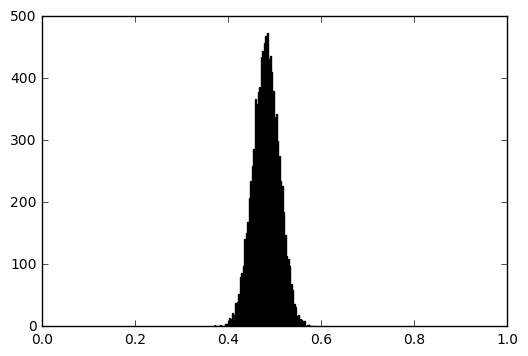

In [83]:
def create_random_matrix(n,p):
    A = np.zeros((n,n))
    for i in range(n):
        A[i,i] = 0
        for j in range(i+1,n):
            if np.random.random() < p:
                A[i,j] = 1
                A[j,i] = 1
    return A
n = 25
N = 10000
d = []
for m in range(N):
    A = create_random_matrix(n,.5)
    B = create_random_matrix(n,.5)
    d.append(sum(sum(A))/n**2)
plt.figure()
plt.hist(d,100)
plt.xlim(0,1)
plt.show()

In [ ]:
import module_main as mm
def offset_sinusoid(off,compare):
    x = np.array([np.cos(x) + 1j*np.sin(x) for x in frange(0,4*np.pi,.01)])
    y = np.array([np.cos(x + off) + 1j*np.sin(x + off) for x in frange(0,4*np.pi,.01)])
    #X = np.stack((x,y),0)
    return compare(np.real(x),np.real(y))
diff = []
for off in frange(0,2*np.pi,.1):
    diff.append(offset_sinusoid(off, lambda X,Y: np.mean(sig.coherence(X,Y)[1])))
plt.figure()
phase = [x for x in frange(0,2*np.pi,.1)] 
plt.plot(phase,diff)
plt.show()

In [ ]:
def DTF_func(X):
    X = np.real(X) 
    p = 2
    A = gm.MVAR_fit(X,p)
    P, freq = gm.DTF(A)
    return np.mean(np.mean(P))
def PDC_func(X):
    X = np.real(X) 
    p = 2
    A = gm.MVAR_fit(X,p)
    P, freq = gm.PDC(A)
    return np.mean(np.mean(P))

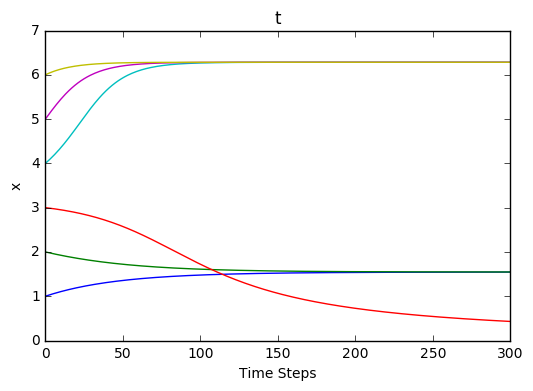

[[ 0.  1.  1.  1.  1.  1.]
 [ 1.  0.  1.  1.  1.  1.]
 [ 1.  1.  0.  1.  1.  1.]
 [ 1.  1.  1.  0.  1.  1.]
 [ 1.  1.  1.  1.  0.  1.]
 [ 1.  1.  1.  1.  1.  0.]]


In [132]:
coherence = lambda X,Y: max(sig.coherence(X,Y)[1])
nodes = [0,1,2,3,4,5]
Graphh = nx.Graph()
Graphh.add_nodes_from(nodes)
Graphh.add_edges_from([(0,1)])
def h(x):
    return -x*np.sin(x)
def f(x,y):
    return y
Matrix = np.identity(6)
Noise = 0
state = [[1],[2],[3],[4],[5],[6]]
tester = nm.nmodel(Graphh,state,h,f,Matrix,Noise,dt=.01)
tester.run(3)
nm.state_course(tester.x[:,0,:])
print(gm.cross_func(tester.x[:,0,:], gm.coherence))
#print(mm.DTF_func(tester.x[:,0,:]))
#print(gm.partial_method(tester.x[:,0,:],gm.r2))

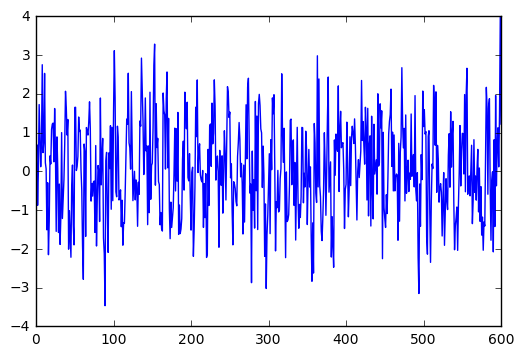

1j

In [54]:
scale = 1
noisy_x = add_noise(oscillator.x,1)
#plt.plot(np.real(oscillator.x[0,0,:]))
plt.plot(np.real(noisy_x[0,0,:]))
plt.show()
add_noise = lambda X,dev: X + np.random.normal(0,dev,X.shape) + 1j*np.random.normal(0,dev,X.shape)
1j


(22, 25, 25)


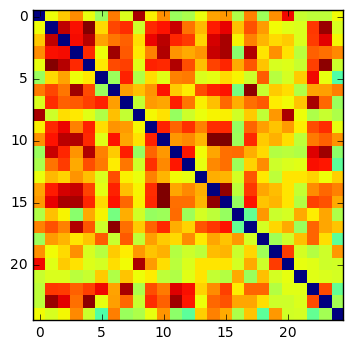

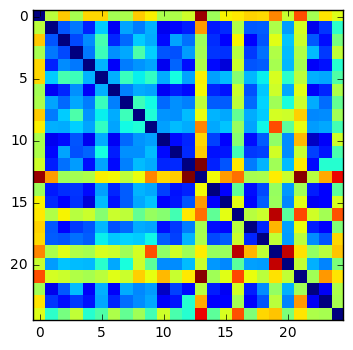

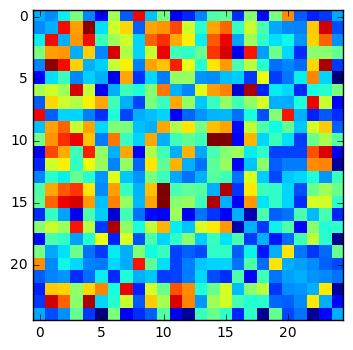

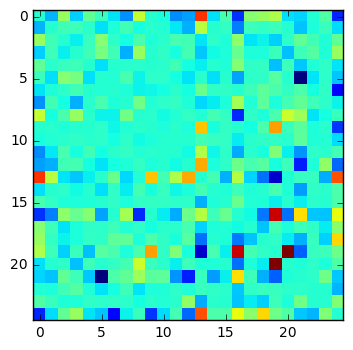

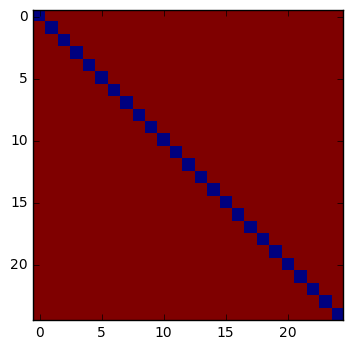

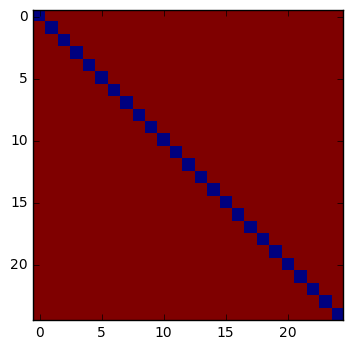

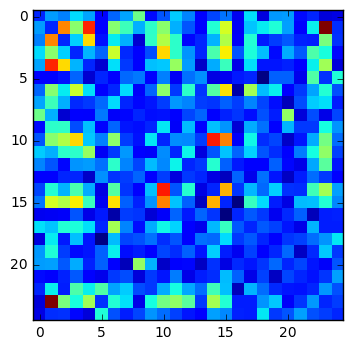

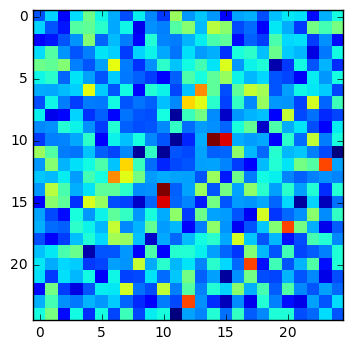

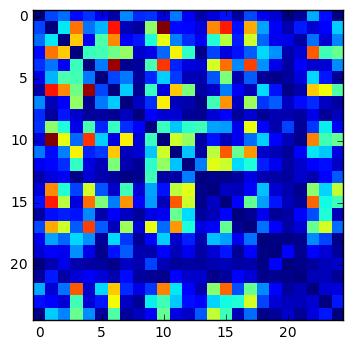

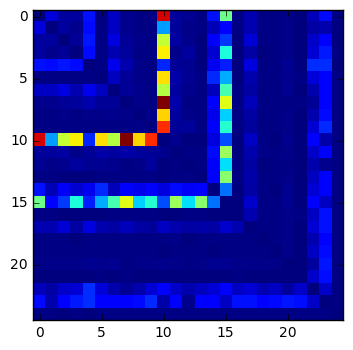

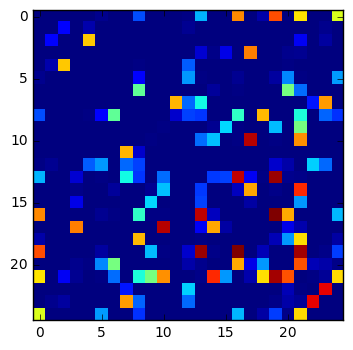

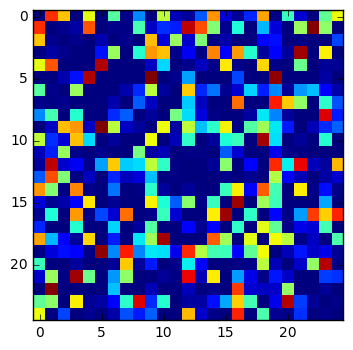

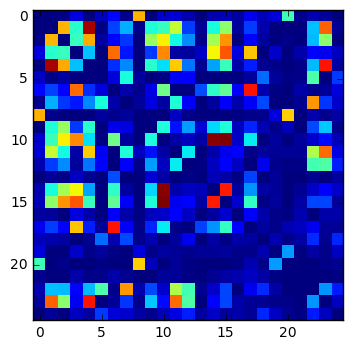

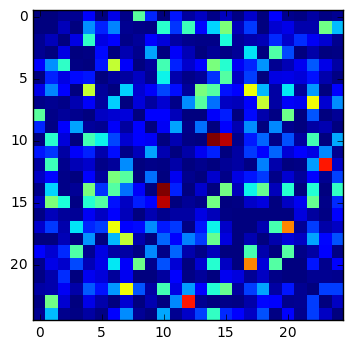

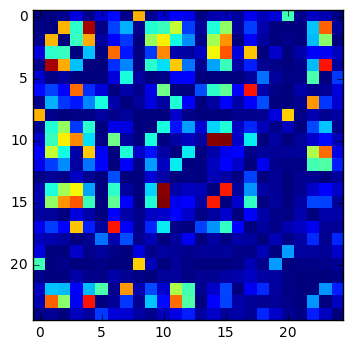

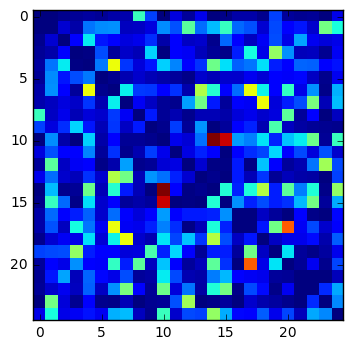

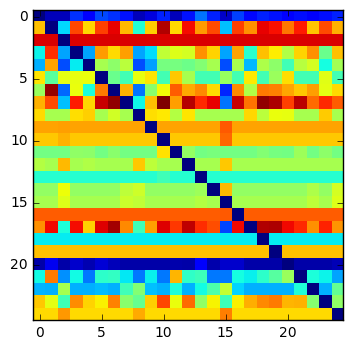

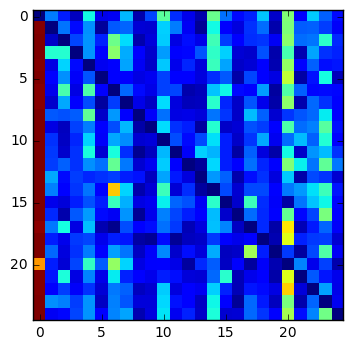

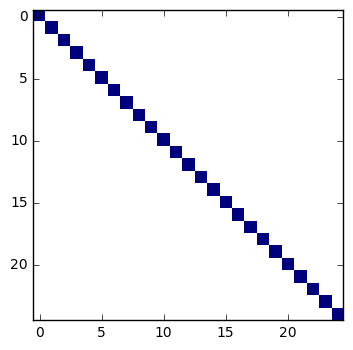

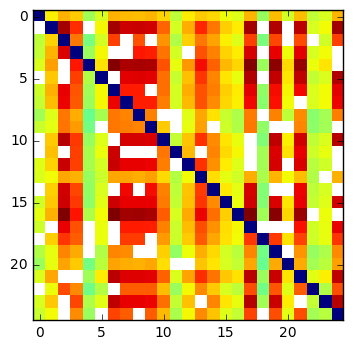

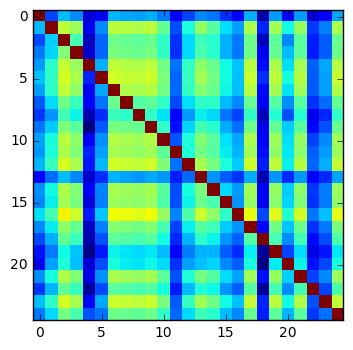

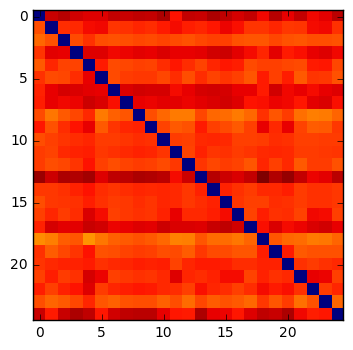

In [12]:
import pickle
with open('measure_normal' , 'rb') as pickle_data:
    measure_normal = np.array(pickle.load(pickle_data))
    x = measure_normal[0]
    print(x.shape)
    plt.figure()
    for mat in x:
        plt.imshow(mat, interpolation= "nearest")
        plt.show()

In [ ]:
with open('adj_data' , 'rb') as pickle_data:
    adj_data = np.array(pickle.load(pickle_data))
    with open('measure_normal' , 'rb') as pickle_data_2:
        measure_normal = np.array(pickle.load(pickle_data_2))
        x = measure_normal[0]
        plt.figure()
        for mat in x:
            plt.plot(adj_data.flatten(),mat.flatten(),'.')
            plt.show()
            

In [32]:
import module_main as mm
import pickle

print('Running main')    

    #run n monte carlo simulations for time t get adjacency and time series data
time_data = []
adj_data = []
n = 1
for i in range(n):
    oscillator  = mm.generate_model()
    t = 20
    oscillator.run(t)
    time_data.append(oscillator.x)
    adj_data.append(nx.to_numpy_matrix(oscillator.G))
with open('time_data' ,'wb') as f:
    pickle.dump(time_data,f)
with open('adj_data', 'wb') as f:
    pickle.dump(adj_data,f)

print('Models Generated')
adj_data = []

Running main
Models Generated


In [37]:
#generate connectivity matrixes for each measure for normal
with open('time_data' , 'rb') as pickle_data:
    trial = np.array(pickle.load(pickle_data))[0]
    noise = [.01,.1,1]
    trial_data = []
    for func in mm.list_of_measures:
            trial_data.append(func(trial[:,0,:]))
    adj_data.append(trial_data)
    for n in noise:
        trial_data = []
        noise_data = mm.add_noise(trial,n)
        for func in mm.list_of_measures:
            trial_data.append(func(noise_data[:,0,:]))
        adj_data.append(trial_data)
print(adj_data.shape)

C:\Users\Rohit\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


KeyboardInterrupt: 

[[[[  0.00000000e+00   5.11779049e-01   7.48612193e-01 ...,
      7.50870552e-01   7.76803778e-01   7.12547789e-01]
   [  5.11779049e-01   0.00000000e+00   5.48582983e-01 ...,
      5.83197268e-01   5.10452278e-01   6.65728388e-01]
   [  7.48612193e-01   5.48582983e-01   0.00000000e+00 ...,
      7.81442504e-01   6.76202156e-01   7.69675507e-01]
   ..., 
   [  7.50870552e-01   5.83197268e-01   7.81442504e-01 ...,
      0.00000000e+00   8.93557630e-01   9.55322043e-01]
   [  7.76803778e-01   5.10452278e-01   6.76202156e-01 ...,
      8.93557630e-01   0.00000000e+00   8.26449359e-01]
   [  7.12547789e-01   6.65728388e-01   7.69675507e-01 ...,
      9.55322043e-01   8.26449359e-01   0.00000000e+00]]

  [[  0.00000000e+00  -2.71680587e-01   2.55835894e-01 ...,
      2.75835215e-01   3.39493509e-01   1.76635779e-01]
   [ -2.71680587e-01   0.00000000e+00  -2.38349591e-01 ...,
     -1.45058844e-01  -2.75755183e-01   6.10404011e-02]
   [  2.55835894e-01  -2.38349591e-01   0.00000000e+00 ...,
 

In [35]:
with open('time_data' , 'rb') as pickle_data:
    trial = np.array(pickle.load(pickle_data))[0]
    print(trial.shape)
    mm.add_noise(trial,.01)

(25, 2, 601)


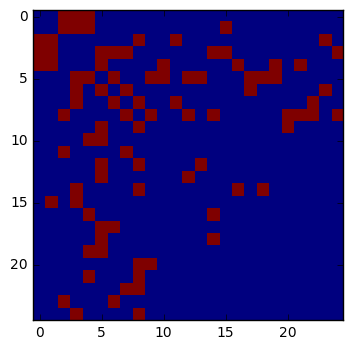

1


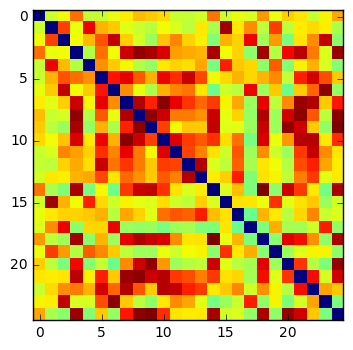

2


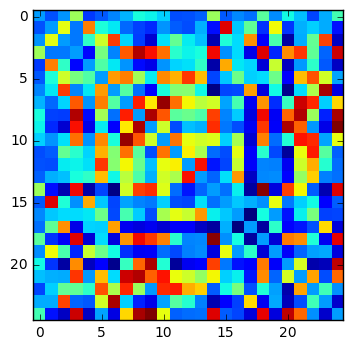

3


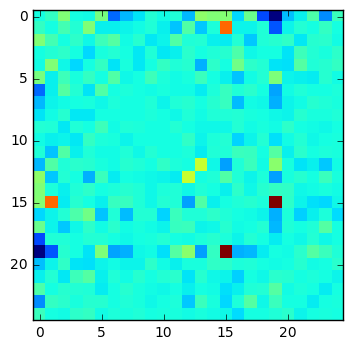

4


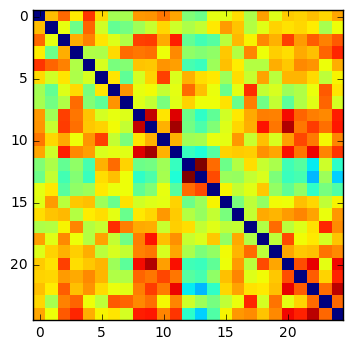

5


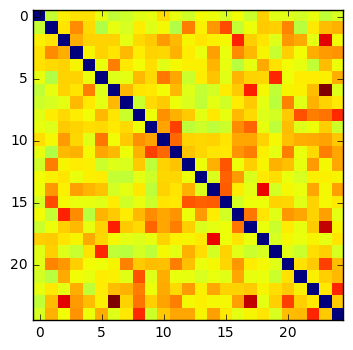

6


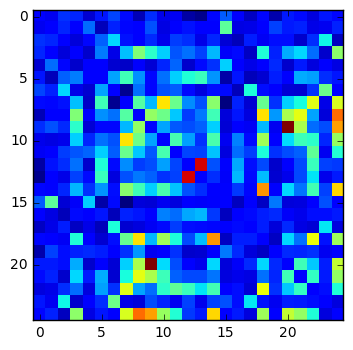

7


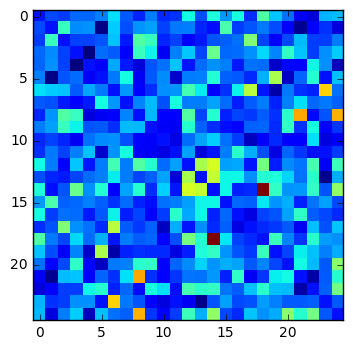

8


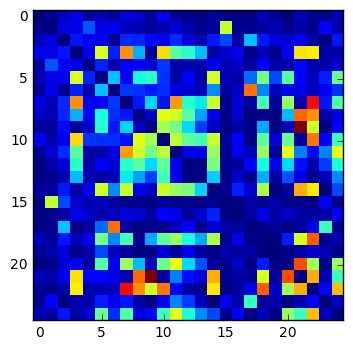

9


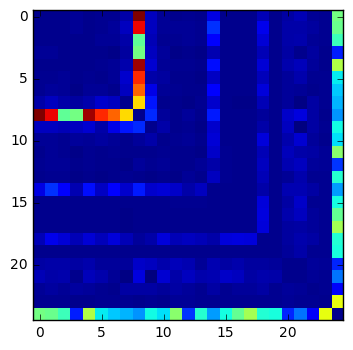

10


TypeError: Invalid dimensions for image data

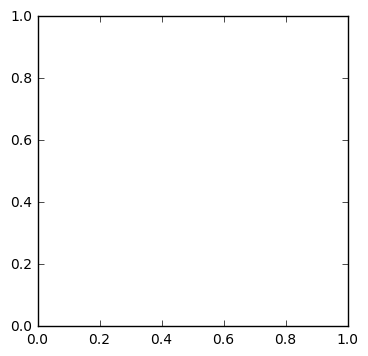

In [30]:
plt.figure()
with open('adj_data' , 'rb') as pickle_data:
    adj = np.array(pickle.load(pickle_data))[0]
    plt.imshow(adj, interpolation= "nearest")
    plt.show()
    i = 1
for mat in adj_data:
    print(i)
    i += 1
    plt.imshow(mat, interpolation= "nearest")
    plt.show()

0.466666666667


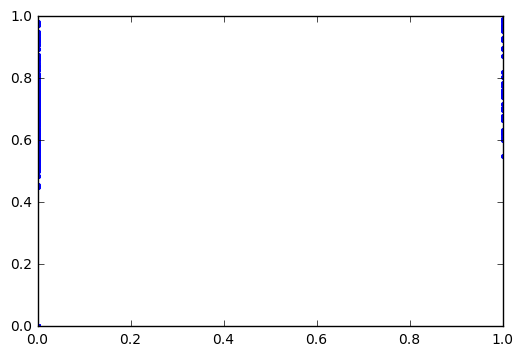

0.953673402979
0.3905002504


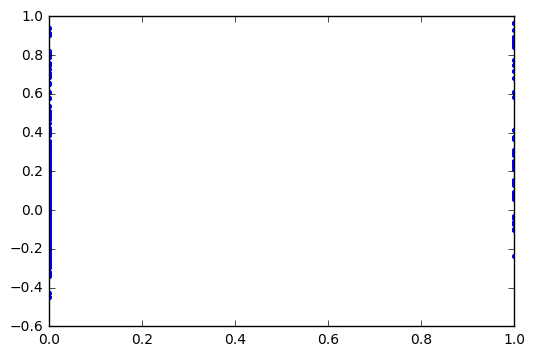

0.843324351996
0.708413743657


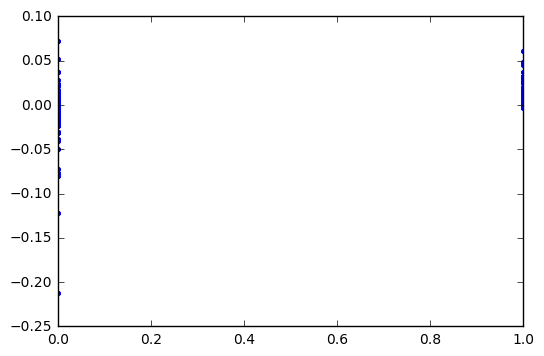

0.01740912859
0.841680423793


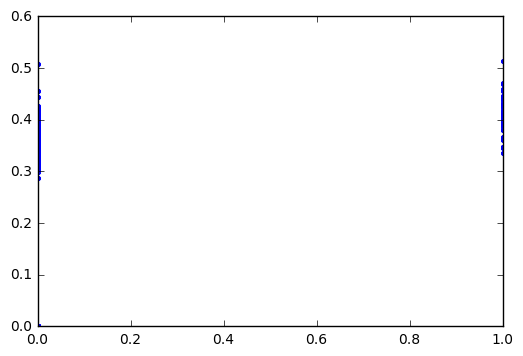

0.424365565486
0.601641268304


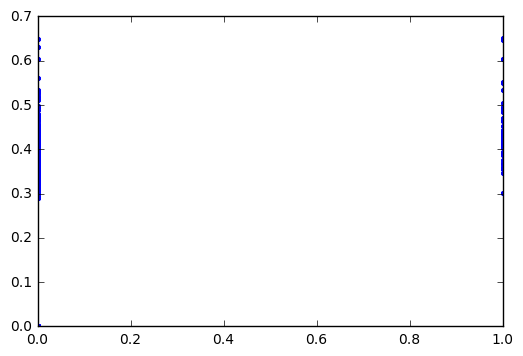

0.548708394841
0.582955018437


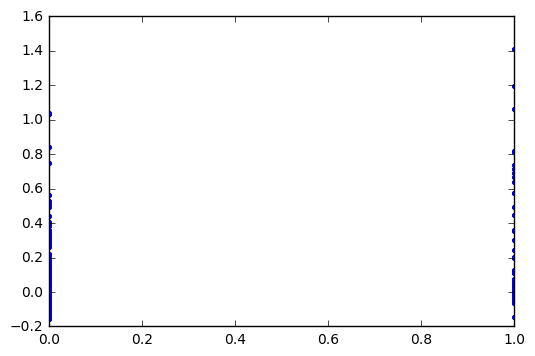

0.574517453151
0.798640694965


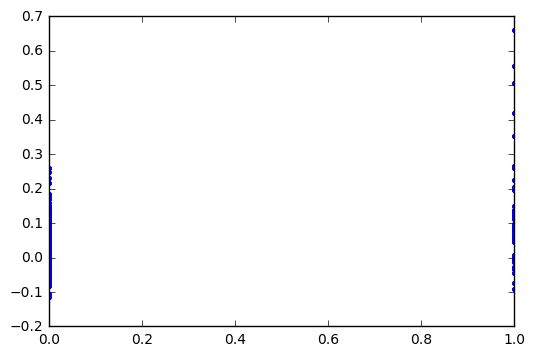

0.267083258873
0.813094537545


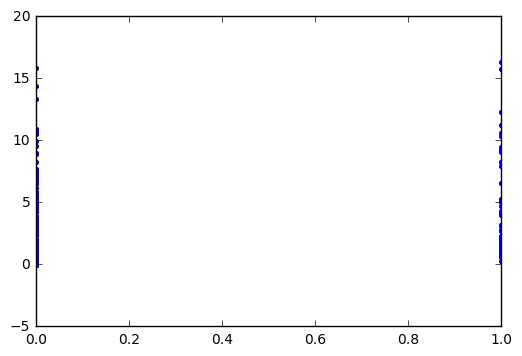

11.2550411597
0


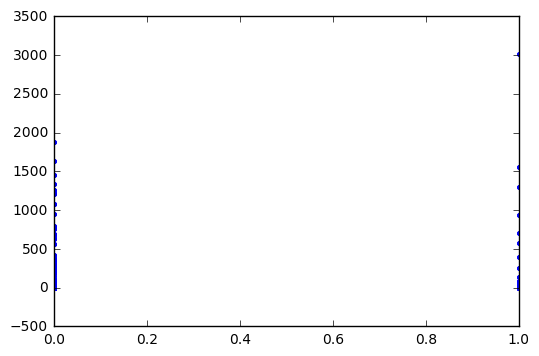

3015.80141031
0


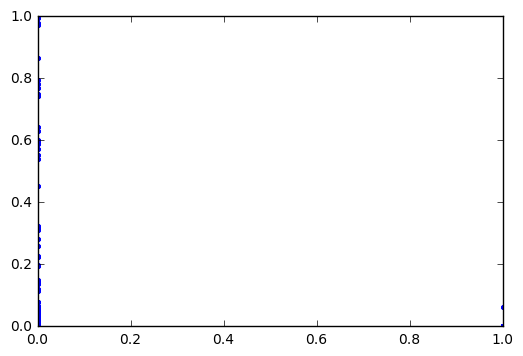

0.994427800339
0.782888117935


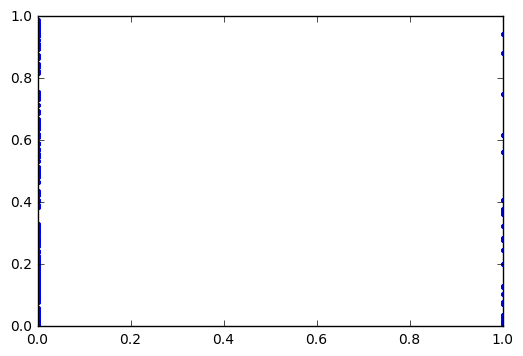

0.988138125368
0.619557911829


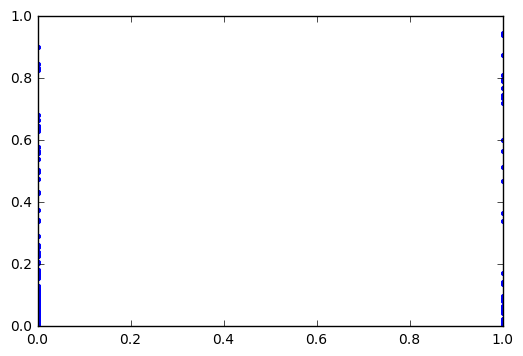

0.720238540982
0.805472080592


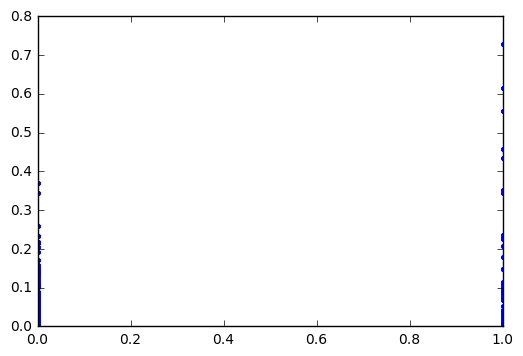

0.344251436958
0.838634788897


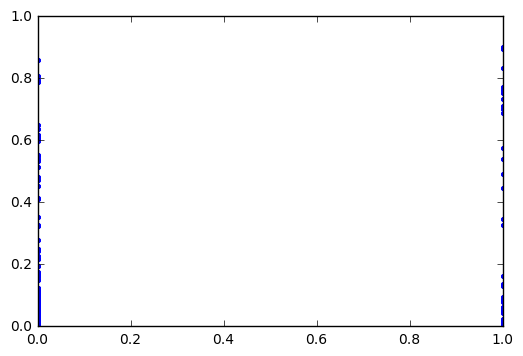

0.687363228365
0.807324357898


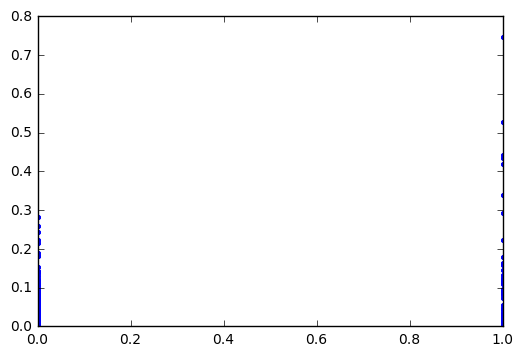

0.293548618975
0.832189307845


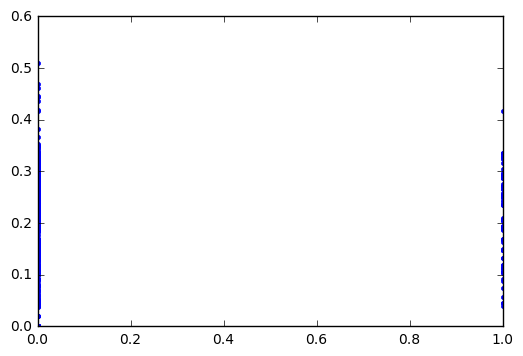

0.510806415421
0.694836302221


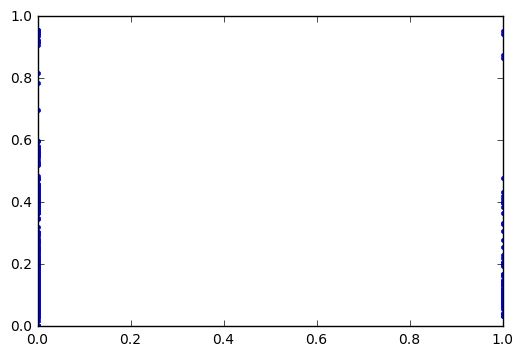

0.955976240097
0.69946962428


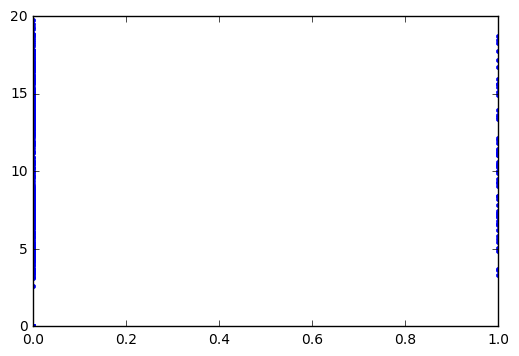

inf
0


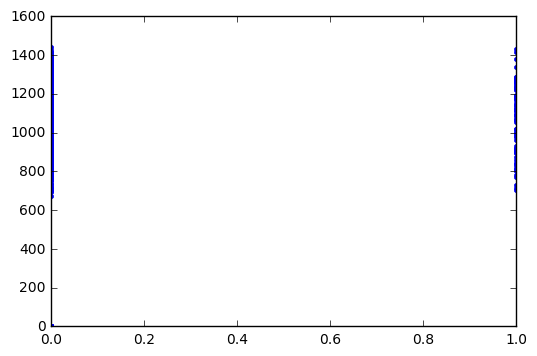

nan
nan


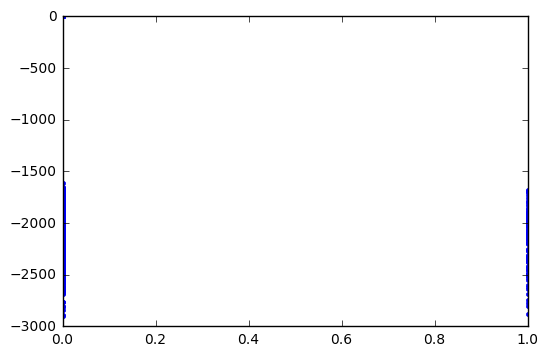

0.0
0


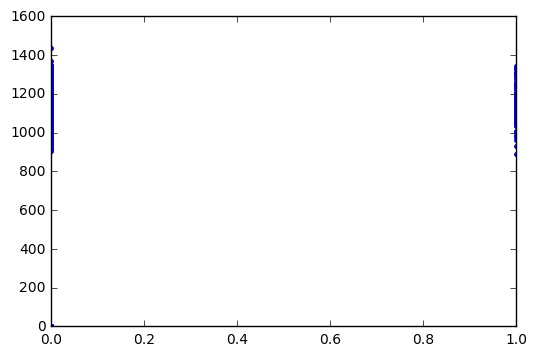

1439.64400585
0


In [49]:
n_data = []
with open('adj_data' , 'rb') as pickle_data:
    adj = np.array(pickle.load(pickle_data))[0]
    n_data.append(gm.distance(adj,create_random_matrix(25,.5)))
    print(sim_data[0])
    plt.figure()
    for mat in adj_data[1]:
        plt.plot(adj.flatten(),mat.flatten(),'.')
        plt.show()
        thr = mm.gen_threshold(adj,mat)
        print(thr)
        arr = mm.thresh_array(mat,thr)
        print(gm.distance(adj,mat))
        n_data.append(gm.distance(adj,mat))
        plt.show()

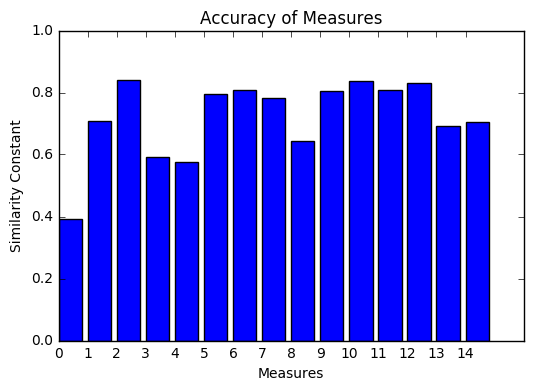

In [81]:
labels = range(len(sim_data))
ax = plt.bar(labels, sim_data)
plt.xticks(range(len(sim_data)), range(len(sim_data)))
plt.xlabel('Measures')
plt.ylabel('Similarity Constant')
plt.title('Accuracy of Measures')
plt.gca().set_ylim((0,1))
fig = plt.gcf()

In [82]:
print(sim_data)

[0.39060795177452518, 0.70839230669609077, 0.84170523645749895, 0.59259727596862666, 0.57476955518260697, 0.79497032905937981, 0.8067688811343201, 0.78297107049603609, 0.64372186377172447, 0.80548581732025937, 0.83732226634415186, 0.80733865360808343, 0.83088491243769746, 0.69148848835255083, 0.70627749530762507]


C:\Users\Rohit\Anaconda3\lib\site-packages\numpy\core\numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


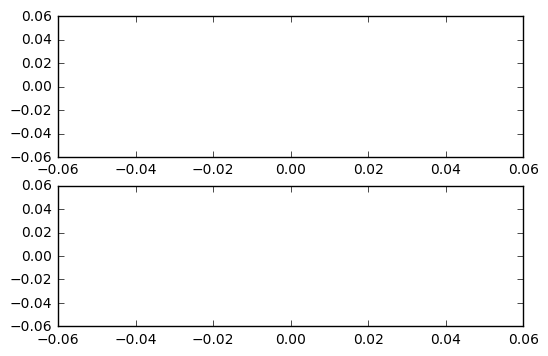

In [129]:
N = 4000
f = np.array([x for x in range(N)])/4
PSD = lambda f: 1/f**2
mag = np.sqrt(PSD(f))
phase = 2*np.pi*np.random.random(N)
FFT = mag * np.exp(1j*phase)
tsig = np.fft.ifft(FFT)

f, Pxx = sig.welch(tsig)

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.plot()
ax1.plot(tsig)
ax2 = fig.add_subplot(212)
ax2.plot(Pxx)
plt.show()

In [165]:
time_delay = lambda X,delays: np.array([node[d:(len(X[0]) - max(delays) + d)] for node,d in zip(X,delays)])
X = tester.x[:,0,:]
delays = [1,2,3,4,5,6]
print(X)
print(time_delay(X,delays))

[[ 1.          1.01146503  1.02269235 ...,  1.54480686  1.54483514
   1.54486294]
 [ 2.          1.991875    1.9838714  ...,  1.54713743  1.54711869
   1.54710042]
 [ 3.          2.99570602  2.9912893  ...,  0.43371862  0.43190331
   0.43010267]
 [ 4.          4.0307854   4.06260857 ...,  6.28318524  6.28318525
   6.28318525]
 [ 5.          5.04781575  5.09528977 ...,  6.28318529  6.28318529
   6.28318529]
 [ 6.          6.01631213  6.0317453  ...,  6.2831853   6.28318531
   6.28318531]]
[[ 1.01146503  1.02269235  1.03368622 ...,  1.54465795  1.54468877
   1.54471906]
 [ 1.9838714   1.97598839  1.96822512 ...,  1.54721729  1.54719657
   1.54717635]
 [ 2.98674681  2.98207549  2.97727222 ...,  0.43925425  0.43739391
   0.43554876]
 [ 4.12942324  4.16443351  4.20051796 ...,  6.28318523  6.28318524
   6.28318524]
 [ 5.23448903  5.27944828  5.32352102 ...,  6.28318529  6.28318529
   6.28318529]
 [ 6.08546719  6.09708195  6.10804153 ...,  6.2831853   6.28318531
   6.28318531]]
